In [107]:
seed = 1024
import numpy as np
np.random.seed(seed)

In [108]:
import scanpy as sc,sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.image import imread
import glob

sys.path.insert(1, '/projects/li-lab/Yue/SpatialAnalysis/py') ##~wont work, has to start with /Users
import ensembl #from st-net

In [109]:
STDir = "/projects/li-lab/Yue/DataPool/Spatial/her2st/data"
resultDir = '/projects/li-lab/Yue/SpatialAnalysis/output'

In [110]:
def read_her2_data(
    rep
) -> sc.AnnData:
    """\
    Read 10x-Genomics-formatted visum dataset.
    In addition to reading regular 10x output,
    this looks for the `spatial` folder and loads images,
    coordinates and scale factors.
    Based on the `Space Ranger output docs`_.
    See :func:`~scanpy.pl.spatial` for a compatible plotting function.
    .. _Space Ranger output docs: https://support.10xgenomics.com/spatial-gene-expression/software/pipelines/latest/output/overview
    Parameters
    ----------
    path
        Path to directory for visium datafiles.
    genome
        Filter expression to genes within this genome.
    count_file
        Which file in the passed directory to use as the count file. Typically would be one of:
        'filtered_feature_bc_matrix.h5' or 'raw_feature_bc_matrix.h5'.
    library_id
        Identifier for the visium library. Can be modified when concatenating multiple adata objects.
    source_image_path
        Path to the high-resolution tissue image. Path will be included in
        `.uns["spatial"][library_id]["metadata"]["source_image_path"]`.
    Returns
    -------
    Annotated data matrix, where observations/cells are named by their
    barcode and variables/genes by gene name. Stores the following information:
    :attr:`~anndata.AnnData.X`
        The data matrix is stored
    :attr:`~anndata.AnnData.obs_names`
        Cell names
    :attr:`~anndata.AnnData.var_names`
        Gene names for a feature barcode matrix, probe names for a probe bc matrix
    :attr:`~anndata.AnnData.var`\\ `['gene_ids']`
        Gene IDs
    :attr:`~anndata.AnnData.var`\\ `['feature_types']`
        Feature types
    :attr:`~anndata.AnnData.obs`\\ `[filtered_barcodes]`
        filtered barcodes if present in the matrix
    :attr:`~anndata.AnnData.var`
        Any additional metadata present in /matrix/features is read in.
    :attr:`~anndata.AnnData.uns`\\ `['spatial']`
        Dict of spaceranger output files with 'library_id' as key
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['images']`
        Dict of images (`'hires'` and `'lowres'`)
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['scalefactors']`
        Scale factors for the spots
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['metadata']`
        Files metadata: 'chemistry_description', 'software_version', 'source_image_path'
    :attr:`~anndata.AnnData.obsm`\\ `['spatial']`
        Spatial spot coordinates, usable as `basis` by :func:`~scanpy.pl.embedding`.
    """
    
    DataDir="/projects/li-lab/Yue/DataPool/Spatial/her2st/data"#SC2200236_EuE-31

    
    library_id = rep
    print(library_id)
    

    # read json scalefactors
    #adata.uns["spatial"][library_id]['scalefactors'] = json.loads(
    #    files['scalefactors_json_file'].read_bytes()
    #)

    #adata.uns["spatial"][library_id]["metadata"] = {
    #    k: (str(attrs[k], "utf-8") if isinstance(attrs[k], bytes) else attrs[k])
    #    for k in ("chemistry_description", "software_version")
    #    if k in attrs
    #}

    # read coordinates
    
    spot_df = pd.read_csv(DataDir+ '/ST-pat/lbl/'+rep+'_labeled_coordinates.tsv', index_col = 0, sep = '\t')
    spot_df.index = spot_df.x.round().astype('int').astype('str')+'x'+spot_df.y.round().astype('int').astype('str')
    spot_df.drop(
        columns=['pixel_x', 'pixel_y'],
        inplace=True,
    )
    print(spot_df)
    coords_csv = DataDir+ '/ST-spotfiles/' + rep + '_selection.tsv'
    coords_df = pd.read_csv(coords_csv, index_col = False, sep = '\t')
    coords_df.index = coords_df.x.astype('str')+'x'+coords_df.y.astype('string')
    
    print(coords_df.loc[spot_df.index])

    st_csv = DataDir+ '/ST-cnts/' + rep + '.tsv.gz'
    st_exp_df = pd.read_csv(st_csv, index_col = 0, sep = '\t')
    
    #adata.obs = positions

    positions = spot_df.join(coords_df.loc[:,['pixel_x','pixel_y']])
    print(positions.head())

    
    positions = positions.reindex(list(st_exp_df.index))
    
    var_df = pd.DataFrame(st_exp_df.columns)
    var_df.index = st_exp_df.columns
    
   
    adata = sc.AnnData(X = st_exp_df,
                       obs = positions,
                       var = var_df)
    adata.uns["spatial"] = dict()

    adata.uns["spatial"][library_id] = dict()

    # check if files exists, continue if images are missing

    adata.uns["spatial"][library_id]['images'] = dict()
    for res in ['hires']:
        try:
            adata.uns["spatial"][library_id]['images'][res] = imread(
                str(glob.glob(DataDir+ '/ST-imgs/' + rep[0] + '/' + rep + '/*.jpg')[0])
            )
        except Exception:
            raise OSError(f"Could not find '{res}_image'")
    
    
    adata.obsm['spatial'] = adata.obs[
        ['pixel_x', 'pixel_y']
    ].to_numpy()
    adata.obs.drop(
        columns=['x', 'y'],
        inplace=True,
    )

    # put image path in uns
#     if source_image_path is not None:
#         # get an absolute path
#         source_image_path = str(Path(source_image_path).resolve())
#         adata.uns["spatial"][library_id]["metadata"]["source_image_path"] = str(
#             source_image_path
#         )

    return adata

    



In [111]:
rep = 'D1'
adata = read_her2_data(rep)

D1
          x       y              label
9x19  9.009  19.036    invasive cancer
9x16  9.008  15.966    invasive cancer
9x13  9.019  12.925    invasive cancer
9x15  9.024  14.951    invasive cancer
9x14  9.026  14.014    invasive cancer
...     ...     ...                ...
8x17  8.024  17.062    invasive cancer
8x16  8.023  15.989    invasive cancer
8x23  8.037  22.971    invasive cancer
9x10  8.958   9.925  connective tissue
9x11  8.995  10.930  connective tissue

[309 rows x 3 columns]
      x   y  new_x   new_y  pixel_x  pixel_y  selected
9x19  9  19  9.009  19.036  2321.36  5243.70         1
9x16  9  16  9.008  15.966  2321.07  4351.14         1
9x13  9  13  9.019  12.925  2324.26  3467.02         1
9x15  9  15  9.024  14.951  2325.71  4056.05         1
9x14  9  14  9.026  14.014  2326.29  3783.63         1
...  ..  ..    ...     ...      ...      ...       ...
8x17  8  17  8.024  17.062  2035.86  4669.79         1
8x16  8  16  8.023  15.989  2035.57  4357.83         1
8x23  8  2

/tmp/ipykernel_247246/1969194093.py:104: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X = st_exp_df,
/projects/compsci/Yue/Anaconda3/envs/tangram-env/lib/python3.8/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (91683375 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [112]:
tavac_df = pd.read_csv('../../output/Her2_tavac_'+rep+'.csv', index_col = 0)


In [113]:
adata.obsm['spatial']

array([[2594.97, 2601.79],
       [2585.12, 2900.08],
       [2576.13, 3189.95],
       [2593.23, 3486.21],
       [2581.64, 3789.44],
       [2590.04, 4061.86],
       [2589.75, 4365.39],
       [2579.9 , 4652.06],
       [2588.01, 4943.66],
       [2592.94, 5263.47],
       [2593.52, 5540.54],
       [2576.42, 5793.19],
       [2599.32, 6133.64],
       [2598.74, 6400.25],
       [2608.3 , 6674.12],
       [2587.44, 6967.76],
       [2592.65, 7261.99],
       [2599.61, 7572.78],
       [2873.51, 2885.84],
       [2887.13, 3168.72],
       [2880.18, 3471.67],
       [2859.31, 3754.85],
       [2876.7 , 4053.72],
       [2880.47, 4358.12],
       [2885.68, 4926.22],
       [2887.42, 5232.36],
       [2872.06, 5507.98],
       [2884.81, 5799.3 ],
       [2888.87, 6117.07],
       [2886.84, 6372.63],
       [2878.73, 6657.84],
       [2896.41, 6948.28],
       [2888.29, 7248.61],
       [2880.47, 7541.38],
       [2880.18, 7831.83],
       [3212.92, 2902.12],
       [3210.6 , 3204.19],
 

In [114]:
adata.obs['spot_id'] = rep +'_'+ adata.obs.index
adata.obs

,label,pixel_x,pixel_y,spot_id
10x10,connective tissue,2594.97,2601.79,D1_10x10
10x11,connective tissue,2585.12,2900.08,D1_10x11
10x12,connective tissue,2576.13,3189.95,D1_10x12
10x13,undetermined,2593.23,3486.21,D1_10x13
10x14,invasive cancer,2581.64,3789.44,D1_10x14
...,...,...,...,...
9x23,invasive cancer,2338.46,6382.22,D1_9x23
9x24,undetermined,2329.76,6664.23,D1_9x24
9x25,connective tissue,2347.15,6961.95,D1_9x25
9x26,connective tissue,2336.43,7246.29,D1_9x26


In [115]:
tavac_df.index = tavac_df.index.str.replace(rep+'_','')

In [116]:
tavac_df = tavac_df.loc[adata.obs.index,:]
tavac_df = tavac_df.drop_duplicates()

In [117]:
tavac_thres = 0.9
tavac_df['Quality'] = ['High reproducible\n attention map' if x > tavac_thres else 'Low reproducible\n attention map' for x in tavac_df['TAVAC']]
#tavac_df.loc[tavac_df['Quality'] == 'Bad',:]

In [118]:
adata.obs = adata.obs.join(tavac_df['TAVAC'])


In [119]:
adata.obs = adata.obs.join(tavac_df['Quality'])
adata.obs

,label,pixel_x,pixel_y,spot_id,TAVAC,Quality
10x10,connective tissue,2594.97,2601.79,D1_10x10,0.985012,High reproducible\n attention map
10x11,connective tissue,2585.12,2900.08,D1_10x11,0.977758,High reproducible\n attention map
10x12,connective tissue,2576.13,3189.95,D1_10x12,0.983884,High reproducible\n attention map
10x13,undetermined,2593.23,3486.21,D1_10x13,0.882683,Low reproducible\n attention map
10x14,invasive cancer,2581.64,3789.44,D1_10x14,0.972736,High reproducible\n attention map
...,...,...,...,...,...,...
9x23,invasive cancer,2338.46,6382.22,D1_9x23,0.974067,High reproducible\n attention map
9x24,undetermined,2329.76,6664.23,D1_9x24,0.971754,High reproducible\n attention map
9x25,connective tissue,2347.15,6961.95,D1_9x25,0.987246,High reproducible\n attention map
9x26,connective tissue,2336.43,7246.29,D1_9x26,0.980900,High reproducible\n attention map


In [120]:
adata.obs.loc[adata.obs.TAVAC < 0.9,:]

,label,pixel_x,pixel_y,spot_id,TAVAC,Quality
10x13,undetermined,2593.23,3486.21,D1_10x13,0.882683,Low reproducible\n attention map
10x26,undetermined,2592.65,7261.99,D1_10x26,0.777014,Low reproducible\n attention map
10x27,undetermined,2599.61,7572.78,D1_10x27,0.870146,Low reproducible\n attention map
11x23,connective tissue,2886.84,6372.63,D1_11x23,0.869046,Low reproducible\n attention map
12x13,connective tissue,3220.74,3498.13,D1_12x13,0.877656,Low reproducible\n attention map
12x16,invasive cancer,3220.45,4369.75,D1_12x16,0.835852,Low reproducible\n attention map
13x28,invasive cancer,3513.20,7850.73,D1_13x28,0.890598,Low reproducible\n attention map
14x26,invasive cancer,3770.58,7266.35,D1_14x26,0.891786,Low reproducible\n attention map
15x22,connective tissue,4077.23,6118.23,D1_15x22,0.881145,Low reproducible\n attention map
15x25,invasive cancer,4078.97,6976.48,D1_15x25,0.893854,Low reproducible\n attention map


/projects/compsci/Yue/Anaconda3/envs/tangram-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/projects/compsci/Yue/Anaconda3/envs/tangram-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/projects/compsci/Yue/Anaconda3/envs/tangram-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/projects/compsci/Yue/Anaconda3/envs/tangram-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


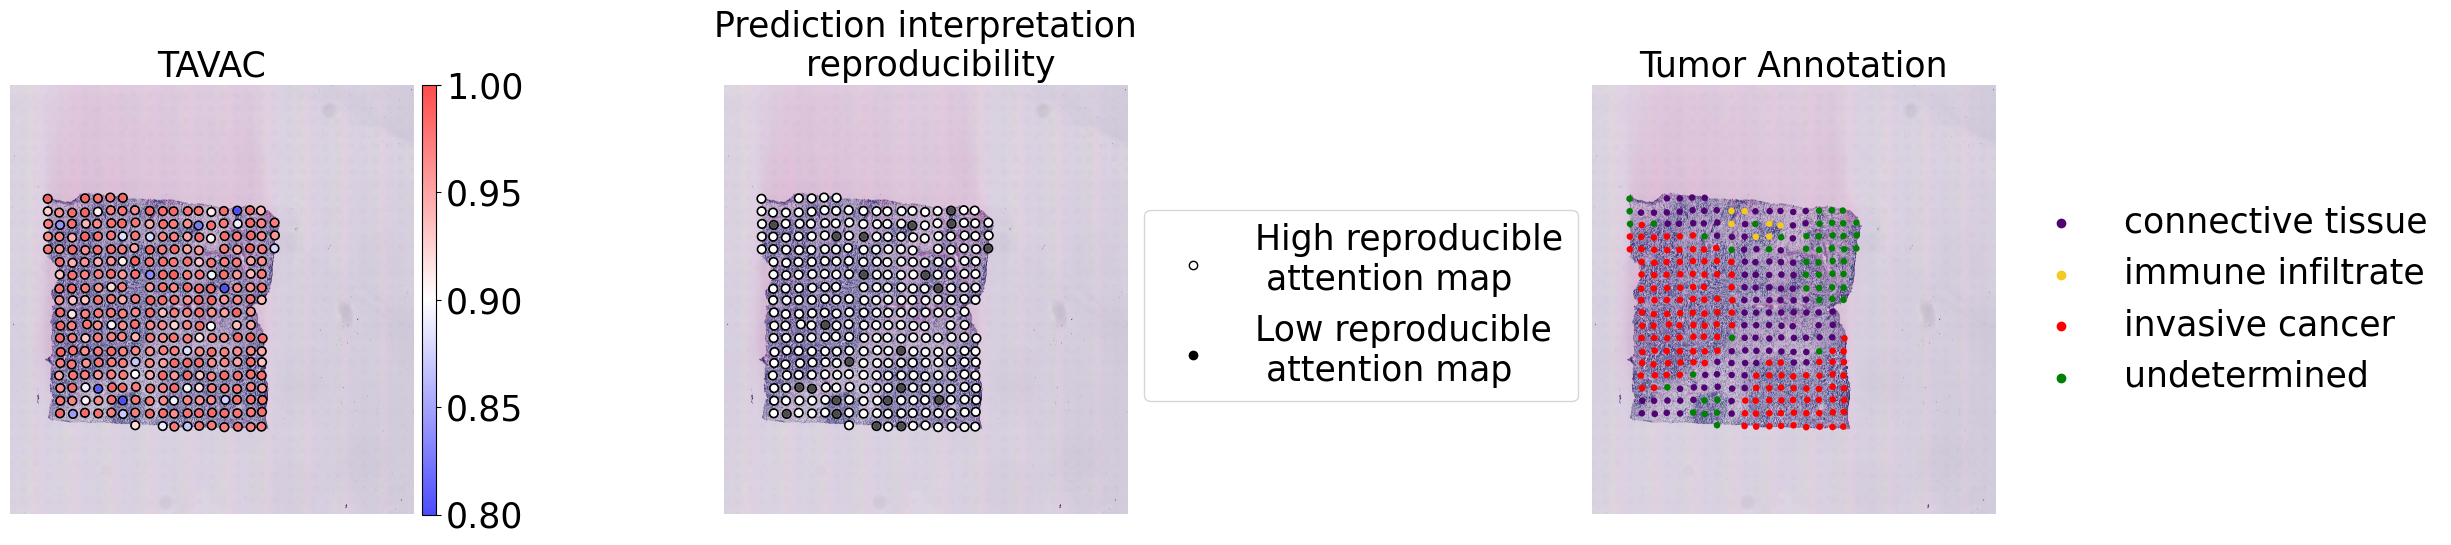

In [121]:
font_size = 25

plt.rcParams.update({'font.size': font_size})
fig, axs = plt.subplots(1, 3, figsize=(30,6))

library_id = rep
img_shape = adata.uns["spatial"][library_id]['images']['hires'].shape

ax = sc.pl.spatial(adata, img_key = "hires", color='TAVAC',
              size=1, spot_size = 150, scale_factor = 1,
              crop_coord=[0, img_shape[1], 0, img_shape[0]],
              title = 'TAVAC',
              add_outline = True,
              vmin = 0.8,vmax = 1,
              na_in_legend = False,
              return_fig = True,
              ax = axs[0],
              show = False,
              #color_map = 'Greys_r'
              color_map = 'bwr'
              #save = 'pretrained_'+ library_id + '_'+gene_predict+ '_prediction'+'.pdf',
              #colorbar_loc = 'bottom'
             )


ax = sc.pl.spatial(adata, img_key = "hires", color='Quality',
              size=1, spot_size = 150, scale_factor = 1,
              crop_coord=[0, img_shape[1], 0, img_shape[0]],
              add_outline = True,
              na_in_legend = False,
              return_fig = True,
              ax = axs[1],
              show = False,
              palette = ('white','black'),
              legend_loc = 'right margin'

              #save = 'pretrained_'+ library_id + '_'+gene_predict+ '_prediction'+'.pdf',
              #colorbar_loc = 'bottom'
             )


sc.pl.spatial(adata, img_key = "hires", color='label',
              size=1, 
              spot_size = 150, 
              scale_factor = 1,
              crop_coord=[0, img_shape[1], 0, img_shape[0]],
              palette = ('#500472', '#f3ca20','red','green','blue','yellow'),
              na_in_legend = False,
              return_fig = True,
              ax = axs[2],
              show = False,
              title = 'label',
              
              #colorbar_loc = 'bottom'
              #save = 'pretrained_'+ library_id + '_'+gene_predict+ '_prediction'+'.pdf'
   
             )
#fig, ax = plt.subplots()

titles = [
            'TAVAC',
            'Prediction interpretation\n reproducibility',
            'Tumor Annotation'
         ]
for i in range(3):
    fig.axes[i].set_axis_off()
    fig.axes[i].set_title(titles[i], fontdict={'fontsize': font_size, 'fontweight': 'medium'})
    fig.axes[i].autoscale_view()


fig.axes[-2].tick_params(labelsize=font_size) 
fig.axes[-1].tick_params(labelsize=font_size) 

leg = fig.axes[1].legend(bbox_to_anchor=(1, 0.75)) #reset location
for ha in leg.legendHandles:
    ha.set_edgecolor("black")

plt.tight_layout()
plt.subplots_adjust(hspace = 0, wspace = 0)
plt.savefig(resultDir+'/pretrained_'+ library_id + '_aggregate'+'.pdf',
            bbox_inches='tight')

In [122]:
img_shape

(9885, 9275, 3)

In [123]:
#??sc.pl.spatial